# AutoGluon Ensemble: GBM, LGBM, XGBoost, CatBoost, RF, Voting, Stacking

이 노트북은 AutoGluon을 사용하여 다양한 회귀 모델을 학습하고 앙상블(Voting, Stacking) 성능을 테스트합니다.
참조: `Plus_7_ensemble.ipynb`

In [1]:
import numpy as np
import pandas as pd

# numpy 소수점 4째자리까지 표현
np.set_printoptions(precision=4)

#### 1. 데이터셋 가져오기

In [2]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()



# print(data.DESCR)

#### 컬럼 소개(california housing)

행의 수: 20640<br>

속성수:8

- MedInc: 블록 그룹의 중간 소득
    - HouseAge:블록 그룹의 중간 주택 연령
    - AveRooms: 블록 그룹의 방 개수
    - AveBedrms: 블록 그룹의 침실 개수
    - Population: 블록 그룹의 인구
    - AveOccup:가구당 평균 거주자 수
    - Latitude: 블록 그룹 위도
    - Longitude: 블록 그룹 경도
    - MedHouseVal: 블록 그룹의 중간 주택 가격(타겟, $100,000 단위)

#### 데이터프레임으로 만들기

In [3]:
df=pd.DataFrame(data['data'], columns=data['feature_names'])
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
df['MedHouseVal'] = data['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### 지도위에 데이터를 시각화

In [6]:
import folium
import branca.colormap as cm
# 위도, 경도의 평균을 중심으로 지도 생성
center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=center, zoom_start=6)

# 데이터가 많으므로 일부만 샘플링하여 시각화 (예: 1000개)
sample_df = df.sample(n=1000, random_state=42)

# 가격에 따른 색상 매핑 함수 (Linear Colormap)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], 
                             index=[sample_df['MedHouseVal'].min(), sample_df['MedHouseVal'].max()],
                             vmin=sample_df['MedHouseVal'].min(),
                             vmax=sample_df['MedHouseVal'].max())
colormap.caption = 'Median House Value'
colormap.add_to(m)

for idx, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,  # 반지름은 고정 (가격과 무관)
        color=colormap(row['MedHouseVal']),
        fill=True,
        fill_color=colormap(row['MedHouseVal']),
        fill_opacity=0.7,
        tooltip=f"Price: {row['MedHouseVal']}"
    ).add_to(m)

In [7]:
m

### 데이터를 분할(train_test_split)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(df.drop('MedHouseVal', axis=1), df['MedHouseVal'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16512, 8), (4128, 8))

### 평가지표(MSE,MAE,RMSE,R2)


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error, r2_score

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler    
from sklearn.preprocessing   import  PolynomialFeatures
from sklearn.pipeline         import  make_pipeline

### Linear Regression

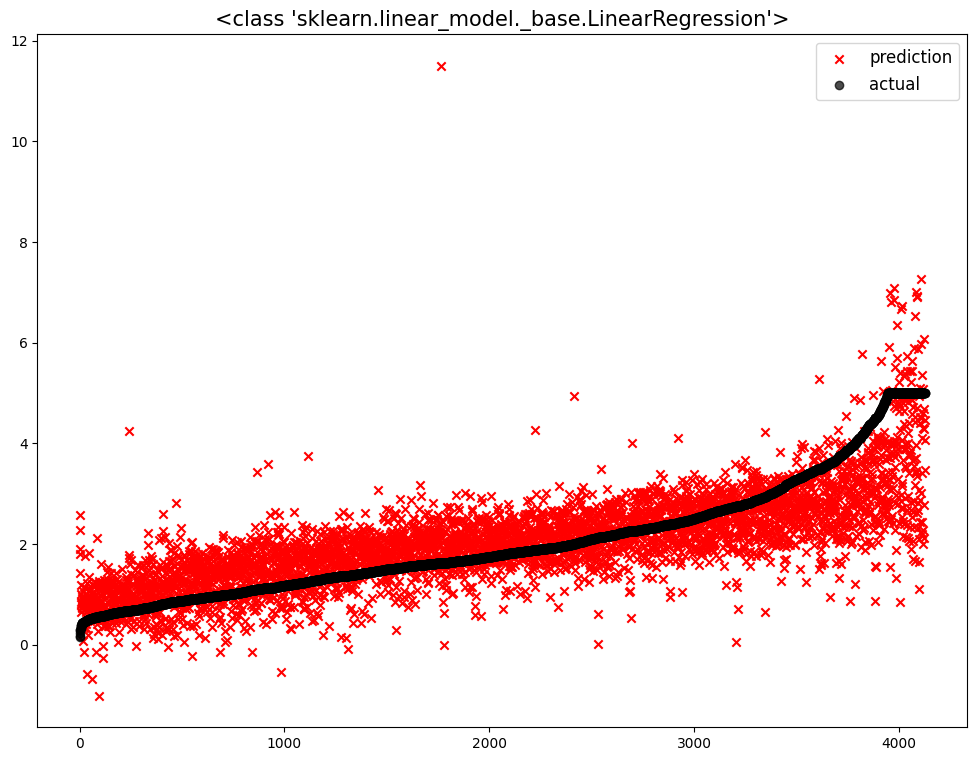

                                               model       mse
0  <class 'sklearn.linear_model._base.LinearRegre...  0.555892


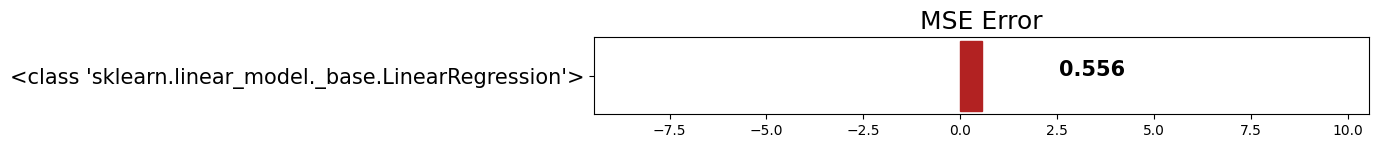

In [12]:
# 1. 모델 생성
linear_reg = LinearRegression(n_jobs= -1)

# 2. 모델 학습
linear_reg.fit(X_train, y_train)

# 3. 모델 예측
y_pred = linear_reg.predict(X_test)

# 4. 모델 평가
mse_eval (LinearRegression,y_pred,y_test)

#### Ridge 

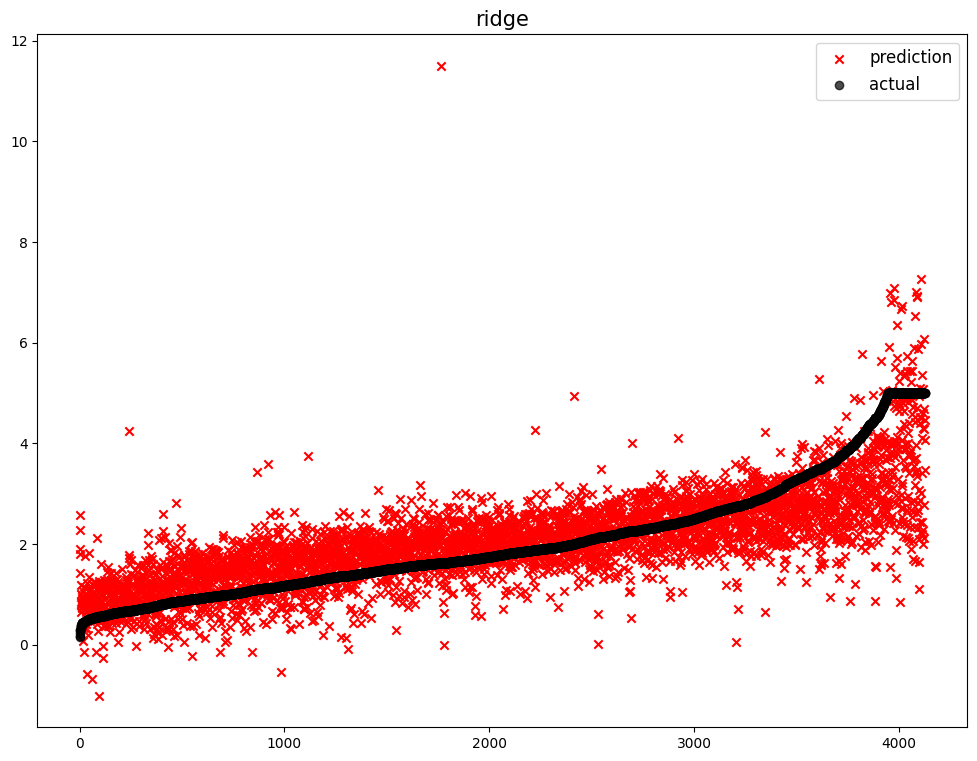

                                               model       mse
0  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
1                                              ridge  0.555891


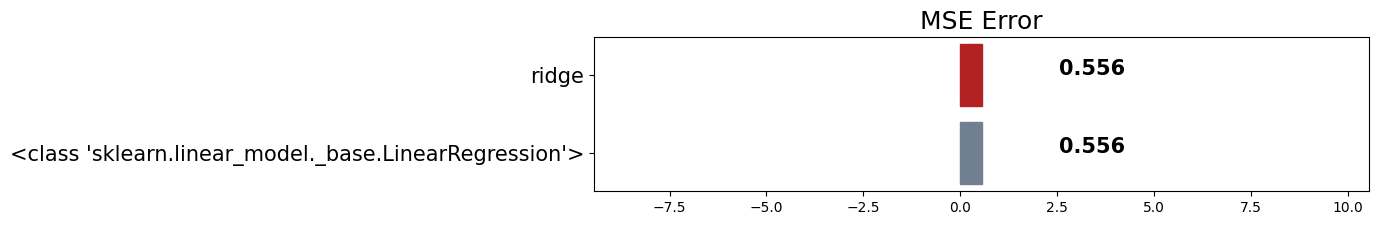

In [13]:
# 1. 모델 생성
ridge = Ridge(alpha=0.01)
# 2. 모델 학습
ridge.fit(X_train, y_train)
# 3. 모델 예측
y_pred = ridge.predict(X_test)
# 4. 모델 평가
mse_eval('ridge', y_pred, y_test)






#### LASSO

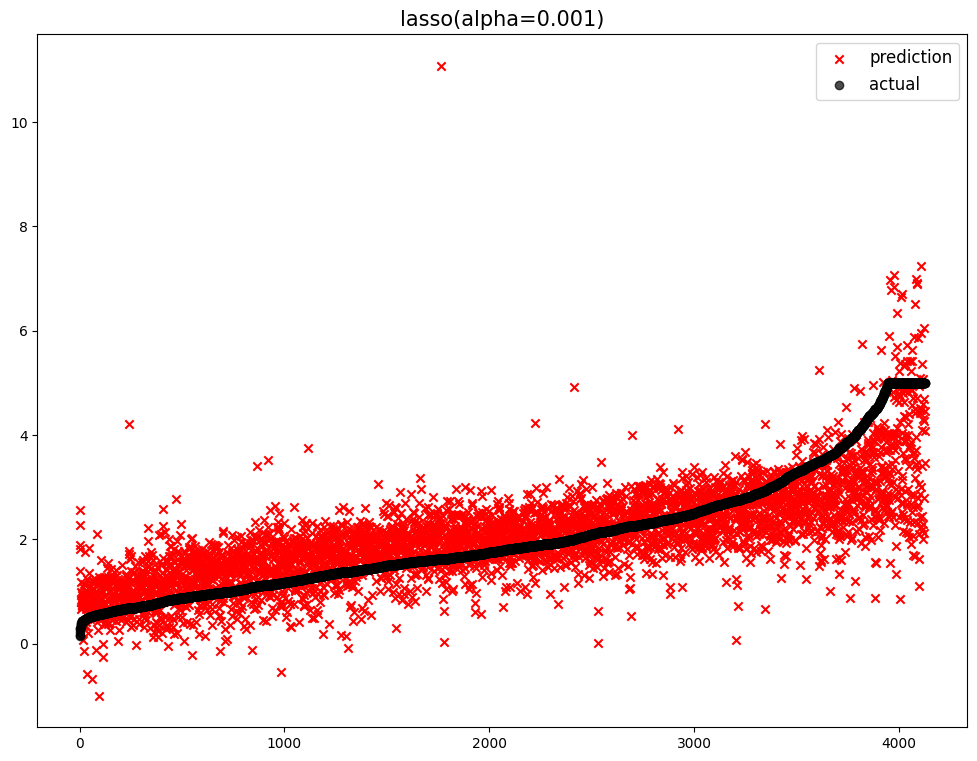

                                               model       mse
0  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
1                                              ridge  0.555891
2                                 lasso(alpha=0.001)  0.553894


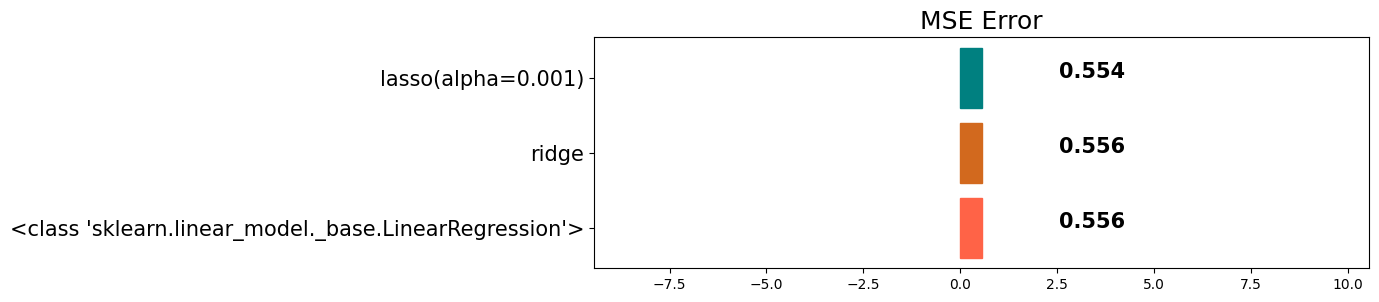

In [14]:
# 1. 모델 생성
lasso= Lasso(alpha=0.001)
# 2. 모델 학습
lasso.fit(X_train , y_train)
# 3. 모델 예측
y_pred = lasso.predict(X_test)
# 4. 모델 평가
mse_eval('lasso(alpha=0.001)', y_pred, y_test)


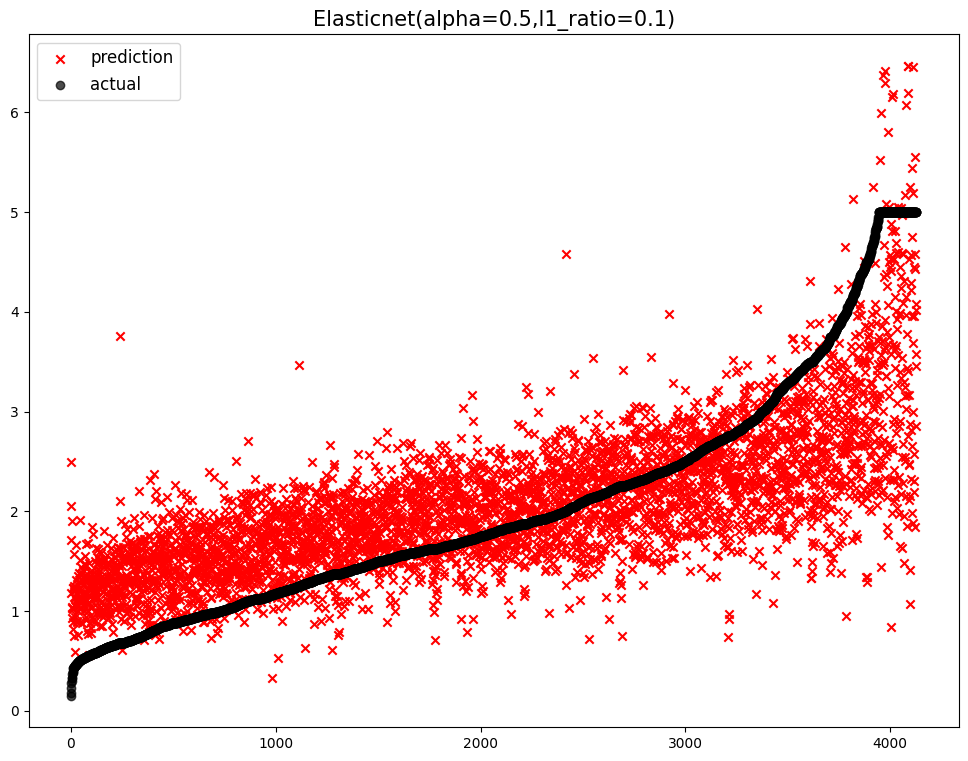

                                               model       mse
0                 Elasticnet(alpha=0.5,l1_ratio=0.1)  0.616577
1  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
2                                              ridge  0.555891
3                                 lasso(alpha=0.001)  0.553894


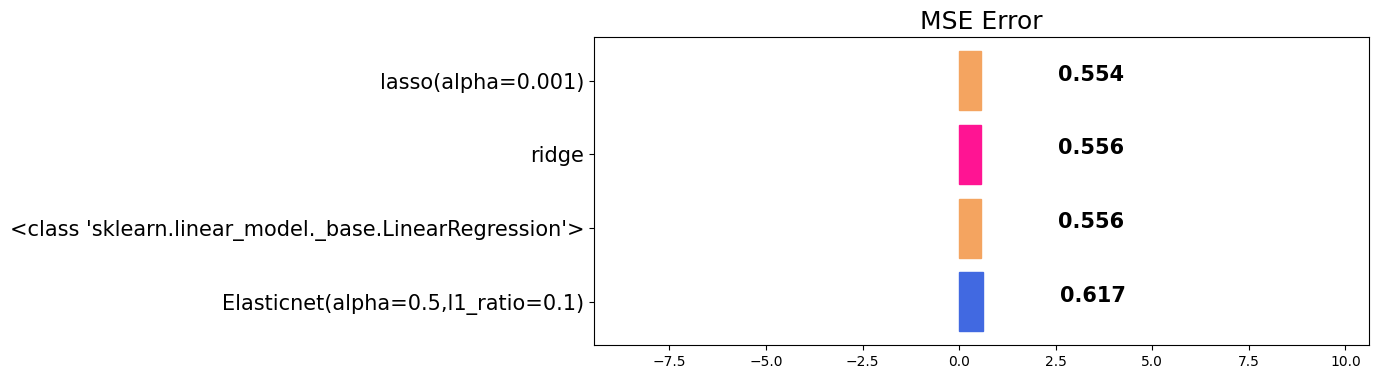

In [15]:
# 1. 모델 생성
ElasticNet= ElasticNet(alpha=0.5,l1_ratio=0.1)
# 2. 모델 학습
ElasticNet.fit(X_train , y_train)
# 3. 모델 예측
y_pred = ElasticNet.predict(X_test)
# 4. 모델 평가
mse_eval('Elasticnet(alpha=0.5,l1_ratio=0.1)', y_pred, y_test)


PipeLine

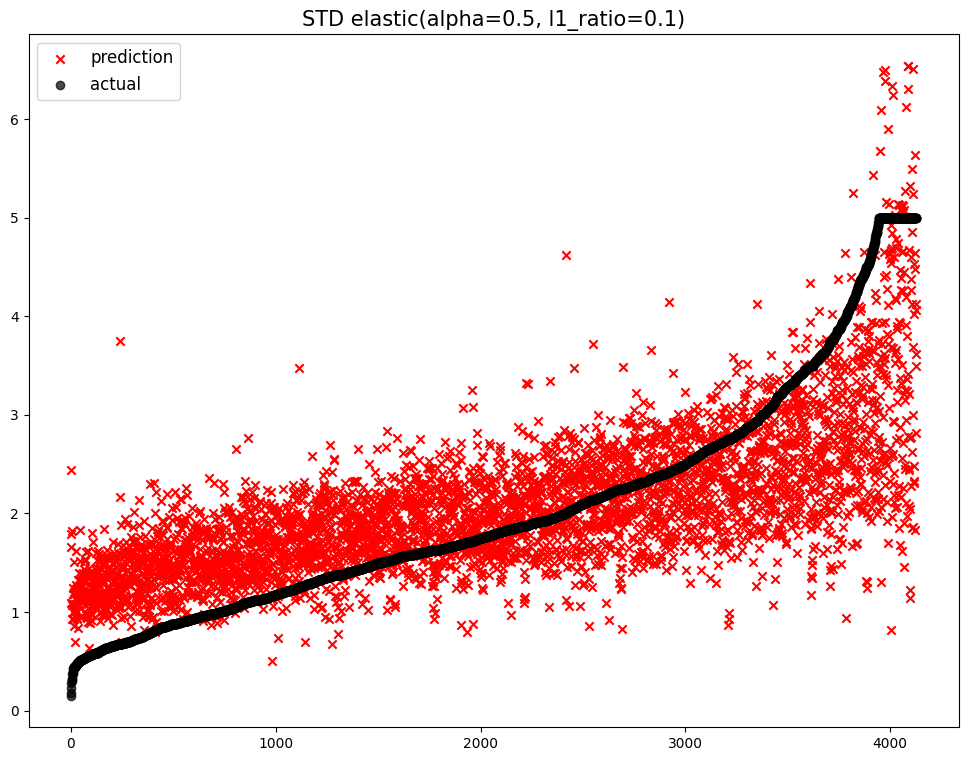

                                               model       mse
0               STD elastic(alpha=0.5, l1_ratio=0.1)  0.635857
1                 Elasticnet(alpha=0.5,l1_ratio=0.1)  0.616577
2  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
3                                              ridge  0.555891
4                                 lasso(alpha=0.001)  0.553894


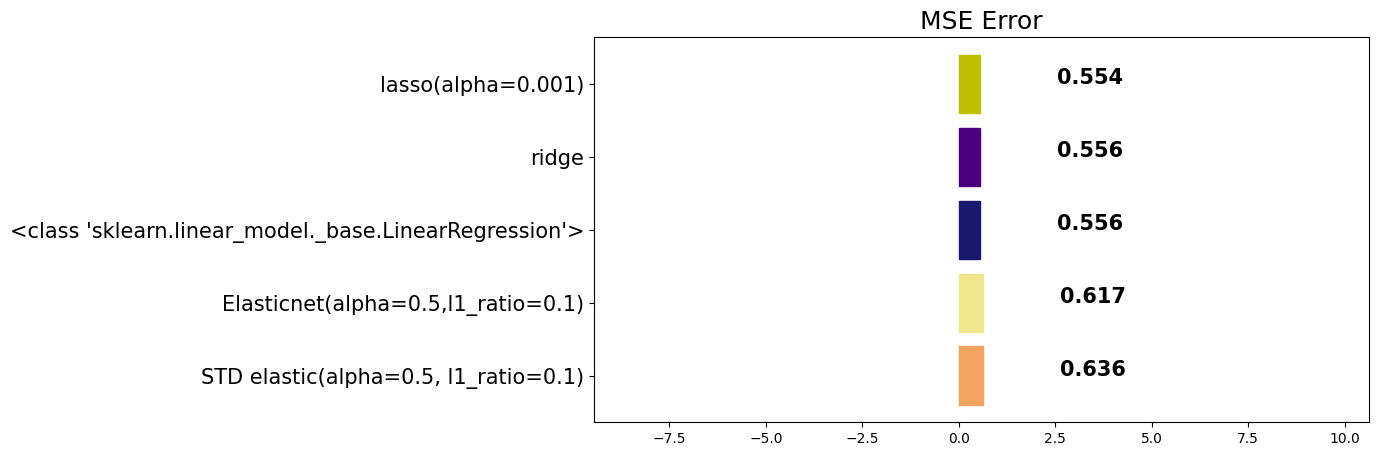

In [16]:
from sklearn.linear_model import ElasticNet

# 1. 모델 생성
ElasticNet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.5)
)


# 2.모델 학습
ElasticNet_pipeline.fit(X_train, y_train)

#3. 모델 예측
y_pred = ElasticNet_pipeline.predict(X_test)

#4. 모델 평가
mse_eval('STD elastic(alpha=0.5, l1_ratio=0.1)', y_pred, y_test)



#### 앙상블(Ensemble)모델

#### Voting Regressor

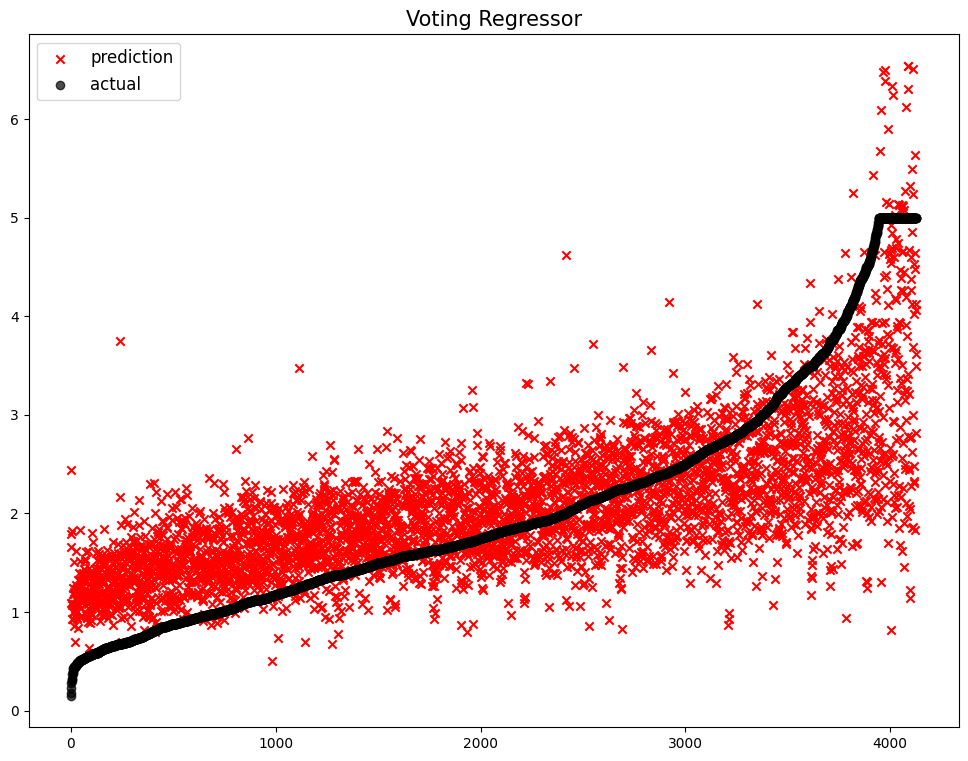

                                               model       mse
0               STD elastic(alpha=0.5, l1_ratio=0.1)  0.635857
1                                   Voting Regressor  0.635857
2                 Elasticnet(alpha=0.5,l1_ratio=0.1)  0.616577
3  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
4                                              ridge  0.555891
5                                 lasso(alpha=0.001)  0.553894


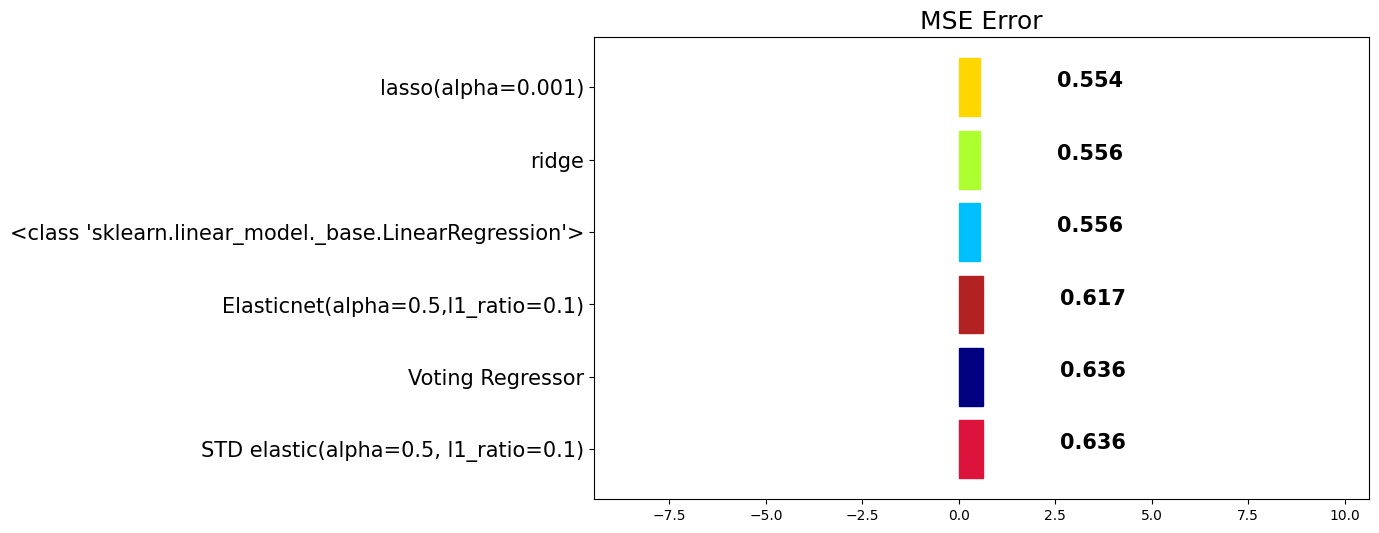

In [26]:
from sklearn.ensemble import VotingRegressor
single_models = [
    ('lasso', lasso),
    ('ridge', ridge),
    ('linear_reg', linear_reg),
    ('std_elastic', ElasticNet_pipeline)
]
# 1. 모델 생성
VotingReg = VotingRegressor(single_models,n_jobs=-1)
# 2. 모델 학습
# Voting_Reg.fit(X_train,y_train)
# 3. 모델 예측
# y_pred = voting_reg.predict(X_test)
# 4. 모델 평가
mse_eval('Voting Regressor', y_pred,y_test)

#### Bagging 방식의 ensemble
 bootstrap AGGregating: BAGGing
##### RandomForest

In [27]:
from sklearn.ensemble import RandomForestRegressor

# 1. 모델 생성
rf_reg = RandomForestRegressor()

# 2. 모델 학습
rf_reg.fit(X_train, y_train)



,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


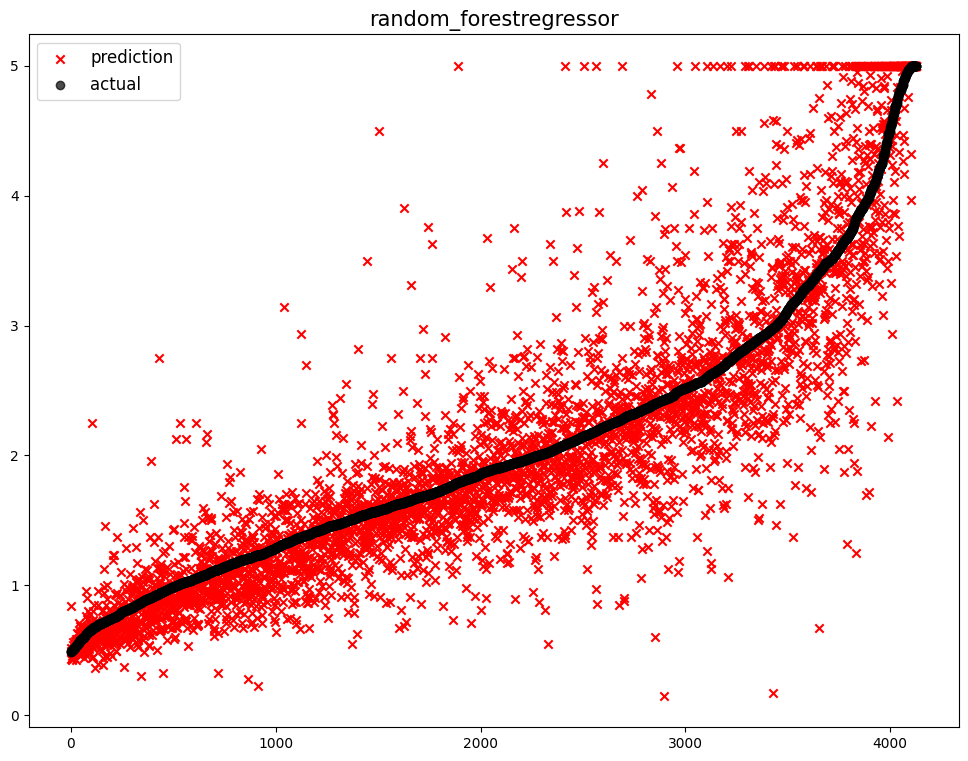

                                               model       mse
0               STD elastic(alpha=0.5, l1_ratio=0.1)  0.635857
1                                   Voting Regressor  0.635857
2                 Elasticnet(alpha=0.5,l1_ratio=0.1)  0.616577
3  <class 'sklearn.linear_model._base.LinearRegre...  0.555892
4                                              ridge  0.555891
5                                 lasso(alpha=0.001)  0.553894
6                             random_forestregressor  0.255055


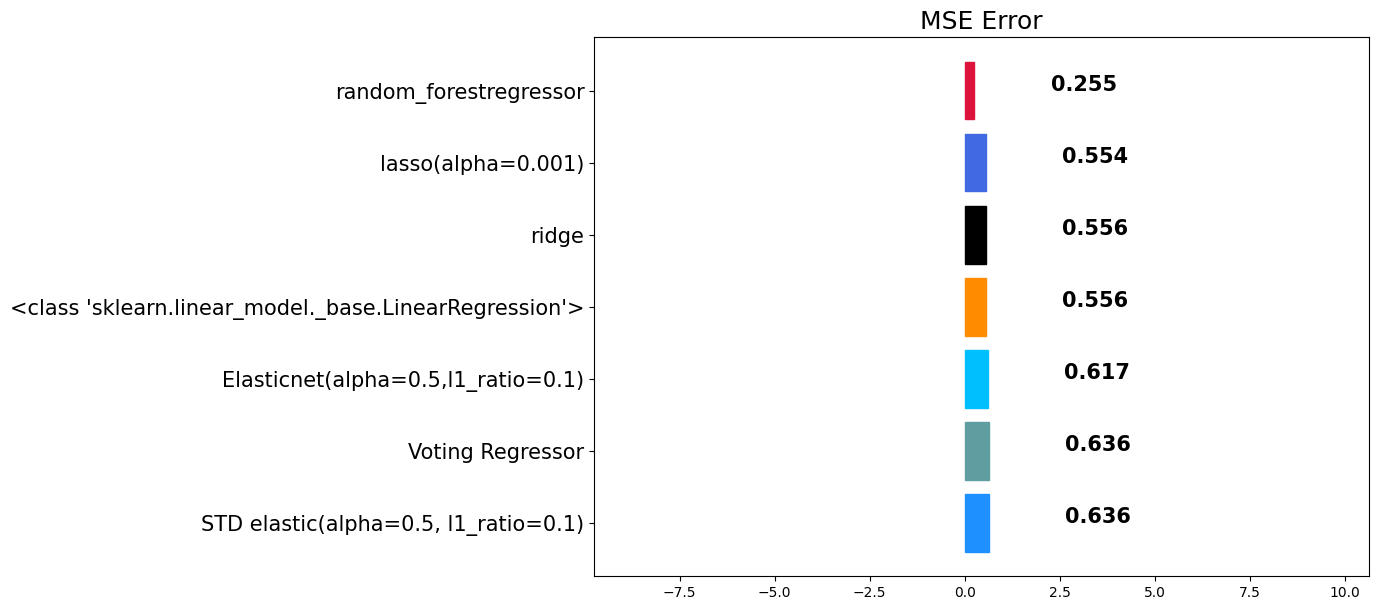

In [28]:
# 3. 모델 예측
y_pred = rf_reg.predict(X_test)

# 4. 모델 평가
mse_eval ('random_forestregressor', y_test, y_pred)


GridSearchCV로 rf_reg를 하이퍼 파라메터 튜닝
나중에 다음과 같은 라이브러리도 사용해 보기를 권장<br>
AutoML 혹은 자동 하이퍼 파라메터 튜닝: Optuna, H2O, autogluon(AMS)


In [ ]:
from sklearn.model_selection import GridSearchCV
# 1.RF 모델 생성
rf_reg_cv = RandomForestRegressor(random_state=42)
param_grid = {
    'n_ estimators' : [100, 200, 300,400,500],
    'max_depth' : [8, 9, 10, 11, 12, 13, None],
}
# GridSearchCV 모델 생성
grid_rg_reg = GridSearchCV(rf_reg_cv, param_grid, cv=5, scoring=neg'mean_squared_error', n_jobs=-1)
# 2. 모델 학습
grid_rg_reg.fit(X_train, y_train)

### 1. 데이터 로드 및 전처리

In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target

print("데이터 크기:", df.shape)
df.head()

In [ ]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

print(data)

In [ ]:
# 학습/테스트 데이터 분리
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)

### 2. 모델 학습 설정 (Hyperparameters & Ensemble)

- **사용 모델**: GBM (LightGBM), XGB (XGBoost), CAT (CatBoost), RF (Random Forest)
- **앙상블 전략**:
    - **Voting (Weighted Ensemble)**: AutoGluon은 기본적으로 성능이 좋은 모델들의 가중 평균(Weighted Ensemble)을 생성합니다.
    - **Stacking**: `num_bag_folds`를 설정하여 K-Fold Bagging 및 Stacking을 수행합니다.

In [ ]:
label = 'MedHouseVal'
eval_metric = 'mean_squared_error'  # 회귀 문제 평가 지표

# 1. 특정 모델 지정 (GBM, XGB, CAT, RF)
# AutoGluon에서 'GBM'은 LightGBM을 의미합니다.
hyperparameters = {
    'GBM': {}, 
    'XGB': {}, 
    'CAT': {}, 
    'RF': {}
}

# 2. Stacking 설정
# num_bag_folds >= 2 이면 스태킹(Stacking)이 활성화됩니다.
num_bag_folds = 5  
num_stack_levels = 1 # 스태킹 레이어 수 (0이면 Bagging만, 1 이상이면 Stacking)

save_path = 'ag_models_california_housing'

### 3. 학습 실행

In [ ]:
    # predictor = TabularPredictor(label=label, eval_metric=eval_metric, path=save_path).fit(
    # train_data,
    # hyperparameters=hyperparameters,
    # num_bag_folds=num_bag_folds,
    # num_stack_levels=num_stack_levels,
    # presets='best_quality',
    # fit_weighted_ensemble=True  # Weighted Ensemble (Voting 유사 효과) 활성화
')'

### 4. 성능 평가 및 리더보드 확인

학습된 모델들의 성능을 비교합니다. 
- `WeightedEnsemble_L2` (또는 L3): 앙상블 모델 (Voting 역할)
- `LightGBM_BAG_L1` 등: Bagging/Stacking된 개별 모델들

In [ ]:
# 리더보드 출력 (테스트 데이터 기준 평가)
leaderboard = predictor.leaderboard(test_data, silent=False)

print("\n--- Top Models ---")
print(leaderboard.head())

### 5. 최종 평가

테스트 데이터 전체에 대한 최종 평가 점수(MSE)를 확인합니다.

In [ ]:
results = predictor.evaluate(test_data)
print("Final Test Results:", results)

### 6. 예측 결과 확인

In [ ]:
# y_pred = predictor.predict(test_data)
 print("First 5 predictions:\n", y_pred.head())
 print("\nFirst 5 actual values:\n", test_data[label].head())